In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msnofrom
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler

In [97]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.float_format",lambda x: '%.3f' % x)
pd.set_option("display.width", 500)

In [98]:
def load():
    data=pd.read_csv("titanic.csv")
    return data
def load_application_train():
    data=pd.read_csv("application_train.csv")
    return data
def grab_col_names(dataframe,cat_th=10,car_th=20):
    cat_cols=[col for col in dataframe.columns if dataframe[col].dtypes=="O"] #tipi obcejt olanları al
    num_but_cat=[col for col in dataframe.columns if dataframe[col].nunique()<cat_th and
             dataframe[col].dtypes!="O"] #numerik görünen kategörikleri aldık
    cat_but_car=[col for col in dataframe.columns if dataframe[col].nunique()>car_th and
                dataframe[col].dtypes=="O"] #kategorik görünen kardinalleri aldık.
    
    cat_cols=cat_cols+num_but_cat #kategörikler güncellendi
    cat_cols=[col for col in cat_cols if col not in cat_but_car] #cat_cols içinde kardinalleri ayırdık
    
    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes!="O"] #tipi objectden farkı olanları getir
    num_cols=[col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations(Gözlem):{dataframe.shape[0]}")
    print(f"Variables(Öznitelik): {dataframe.shape[1]}")
    print(f"cat_cols:{len(cat_cols)}")
    print(f"num_cols:{len(num_cols)} ")
    print(f"cat_but_car:{len(cat_but_car)} ")
    print(f"num_but_cat:{len(num_but_cat)} ")
    
    return cat_cols,num_cols,cat_but_car
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def chech_outlier(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name]>up_limit) | (dataframe[col_name]<low_limit)].any(axis=None):
        return True
    else:
        return False
    
def grab_outliers(dataframe,col_name,index=False):
    low,up=outlier_thresholds(dataframe,col_name)

    if dataframe[((dataframe[col_name]<low) | (dataframe[col_name]>up))].shape[0]>10:
        print(dataframe[((dataframe[col_name]<low)) | (dataframe[col_name]>up)].head())
    else:
        print(dataframe[((dataframe[col_name]<low)) | (dataframe[col_name]>up)])

    if index:
        outlier_index=dataframe[((dataframe[col_name]<low)| (dataframe[col_name]>up))].index
        return outlier_index
    
def replace_with_threshlods(dataframe,veriable):
    low_limit,up_limit=outlier_thresholds(dataframe,veriable)
    dataframe.loc[(dataframe[veriable]>up_limit),veriable]=up_limit
    dataframe.loc[(dataframe[veriable]>low_limit),veriable]=low_limit

def remove_outlier(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    dataframe=dataframe[~((dataframe[col_name]<low_limit) | (dataframe[col_name]>up_limit))]
    return dataframe

In [99]:
df=load()
df.shape

(891, 12)

In [100]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [101]:
##DEgisken isimlerini büyültelim
df.columns=[col.upper() for col in df.columns]

## 1-) Feature Engineering

In [102]:
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'MALE') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'MALE') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'MALE') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'FEMALE') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'FEMALE') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'FEMALE') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [103]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,nan
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,38.000,NO,mature,nan
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,nan
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature,nan
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature,nan


In [104]:
df.shape

(891, 22)

In [105]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)

Observations(Gözlem):891
Variables(Öznitelik): 22
cat_cols:14
num_cols:5 
cat_but_car:3 
num_but_cat:8 


In [106]:
cat_cols

['SEX',
 'EMBARKED',
 'NEW_TITLE',
 'NEW_IS_ALONE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT',
 'SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'NEW_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [107]:
num_cols

['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [108]:
num_cols=[col for col in num_cols if "PASSENGERID" not in col]

In [109]:
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

## 2. Outliers (Aykırı Değerler)


In [110]:
for col in num_cols:
    print(col,chech_outlier(df,num_cols))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [111]:
for col in num_cols:
    replace_with_threshlods(df,col)

In [112]:
for col in num_cols:
    print(col,chech_outlier(df,num_cols))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [113]:
## 3. Null (Eksik Değerler)


In [114]:
def missing_values_table(dataframe,na_name=False):
    na_columns=[col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
    n_miss=dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio=(dataframe[na_columns].isnull().sum() / dataframe.shape[0]*100).sort_values(ascending=True)
    missing_df=pd.concat([n_miss,np.round(ratio,2)],axis=1,keys=["n_miss","ratio"])
    print(missing_df,end="\n")
    if na_name:
        return na_columns

In [115]:
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
EMBARKED             2  0.220


In [116]:
df.drop("CABIN",inplace=True,axis=1)

In [117]:
remove_cols=["TICKET","NAME"]
df.drop(remove_cols,inplace=True,axis=1)

In [118]:
missing_values_table(df)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
EMBARKED             2  0.220


In [119]:
df["AGE"]=df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [120]:
missing_values_table(df)
#yaş değişkenine bağlı olan değerler de boş görünüyor
#yaş üzerinden oluşturdugumuz değişkenleri tekrardan oluşturuyoruz

                n_miss  ratio
NEW_AGE_PCLASS     177 19.870
EMBARKED             2  0.220


In [121]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'MALE') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'MALE') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'MALE') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'FEMALE') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'FEMALE') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'FEMALE') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [122]:
missing_values_table(df)

          n_miss  ratio
EMBARKED       2  0.220


In [123]:
df=df.apply(lambda x:x.fillna(x.mode()[0]) if (x.dtype=="O" and len(x.unique())<=10) else x,axis=0)

In [124]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## 4-) Label Encoding

In [125]:
num_cols=[col for col in df.columns if df[col].dtype not in ["float64","int64"]
         and df[col].nunique()==2]
num_cols

['SEX', 'NEW_CABIN_BOOL', 'NEW_IS_ALONE']

In [126]:

def label_encoder(dataframe, binary_cols):
    labelencoder = LabelEncoder()
    for col in binary_cols:
        dataframe[col] = labelencoder.fit_transform(dataframe[col])
    return dataframe

df = label_encoder(df, num_cols)
def one_hot_encoder(dataframe,categorical_cols,drop_first=True):
    dataframe=pd.get_dummies(dataframe,columns=categorical_cols,drop_first=drop_first)
    return dataframe

def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts()
                       ,"Ratio":100*dataframe[col_name].value_counts()/len(dataframe)}))
    print("###########################################################")
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show()

def rare_analyser(dataframe,target,cat_cols):
    for col in cat_cols:
        print(col,":",len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT":dataframe[col].value_counts()
                           ,"RATIO":dataframe[col].value_counts()/len(dataframe)
                           ,"TARGET_MEAN":dataframe.groupby(col)[target].mean()}),end="\n\n")
        
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [127]:
for col in num_cols:
    label_encoder(df,num_cols)

In [128]:
num_cols=[col for col in df.columns if df[col].dtype not in ["float64","int64"]
         and df[col].nunique()==2]
num_cols

[]

## 5-) Rare Encoding

In [129]:
rare_analyser(df,"SURVIVED",cat_cols)

SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189

EMBARKED : 3
          COUNT  RATIO  TARGET_MEAN
EMBARKED                           
C           168  0.189        0.554
Q            77  0.086        0.390
S           646  0.725        0.339

NEW_TITLE : 17
           COUNT  RATIO  TARGET_MEAN
NEW_TITLE                           
Capt           1  0.001        0.000
Col            2  0.002        0.500
Countess       1  0.001        1.000
Don            1  0.001        0.000
Dr             7  0.008        0.429
Jonkheer       1  0.001        0.000
Lady           1  0.001        1.000
Major          2  0.002        0.500
Master        40  0.045        0.575
Miss         182  0.204        0.698
Mlle           2  0.002        1.000
Mme            1  0.001        1.000
Mr           517  0.580        0.157
Mrs          125  0.140        0.792
Ms             1  0.001        1.000
Rev            6  0.007      

In [130]:
df=rare_encoder(df,0.01)

In [131]:
df["NEW_TITLE"].value_counts()

NEW_TITLE
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

## 6-) One HOt Encoding

In [132]:
ohe_cols=[col for col in df.columns if 10>=df[col].nunique()>2]
ohe_cols

['PCLASS',
 'SIBSP',
 'PARCH',
 'EMBARKED',
 'NEW_NAME_WORD_COUNT',
 'NEW_TITLE',
 'NEW_FAMILY_SIZE',
 'NEW_AGE_PCLASS']

In [133]:
df=one_hot_encoder(df,ohe_cols)

In [134]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_PCLASS_-13.375,NEW_AGE_PCLASS_-6.6875
0,1,0,1,-6.688,-26.724,0,5,0,0,young,nan,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
1,2,1,0,-6.688,-26.724,1,5,0,0,young,nan,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True
2,3,1,0,-6.688,-26.724,0,5,0,1,young,nan,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,-6.688,-26.724,1,5,0,0,young,nan,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True
4,5,0,1,-6.688,-26.724,0,5,0,1,young,nan,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [137]:
###df['your_categorical_column'] = df['your_categorical_column'].replace({True: 1, False: 0})

In [138]:
df.shape

(891, 48)

In [151]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)
num_cols
num_cols=[col for col in num_cols if "PASSENGERID" not in col]
num_cols

Observations(Gözlem):891
Variables(Öznitelik): 48
cat_cols:47
num_cols:1 
cat_but_car:0 
num_but_cat:45 


[]

In [152]:
rare_analyser(df,"SURVIVED",cat_cols)

NEW_AGE_CAT : 1
             COUNT  RATIO  TARGET_MEAN
NEW_AGE_CAT                           
young          891  1.000        0.384

NEW_SEX_CAT : 1
             COUNT  RATIO  TARGET_MEAN
NEW_SEX_CAT                           
nan            891  1.000        0.384

SURVIVED : 2
          COUNT  RATIO  TARGET_MEAN
SURVIVED                           
0           549  0.616        0.000
1           342  0.384        1.000

SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189

AGE : 1
        COUNT  RATIO  TARGET_MEAN
AGE                              
-6.688    891  1.000        0.384

FARE : 1
         COUNT  RATIO  TARGET_MEAN
FARE                              
-26.724    891  1.000        0.384

NEW_CABIN_BOOL : 2
                COUNT  RATIO  TARGET_MEAN
NEW_CABIN_BOOL                           
0                 687  0.771        0.300
1                 204  0.229        0.667

NEW_NAME_COUNT : 1
        

In [154]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
#gereksiz sütunlar

In [155]:
useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [156]:
### df.drop(useless_cols,inplace=True,axis=1)
#Sİlmek de bir tercih

## 7 Standart Scaler

In [158]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [160]:
#scaler=StandardScaler()
#df[num_cols]=scaler.fit_transform(df[num_cols])
#df[num_cols].head()

In [164]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_PCLASS_-13.375,NEW_AGE_PCLASS_-6.6875
0,1,0,1,-6.688,-26.724,0,5,0,0,young,nan,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
1,2,1,0,-6.688,-26.724,1,5,0,0,young,nan,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True
2,3,1,0,-6.688,-26.724,0,5,0,1,young,nan,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,-6.688,-26.724,1,5,0,0,young,nan,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True
4,5,0,1,-6.688,-26.724,0,5,0,1,young,nan,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


## 8-) Modelleme

In [184]:
from sklearn.model_selection import train_test_split
y=df["SURVIVED"]
x=df.drop(["PASSENGERID","SURVIVED"],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=17)
print(x_test.shape)
print(y_test.shape)

print(x_train.shape)
print(y_train.shape)

(268, 46)
(268,)
(623, 46)
(623,)


In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [187]:
# RandomForestClassifier modeli eğitme
#rf_model = RandomForestClassifier(random_state=46).fit(x_train, y_train)

# Doğruluk skorunu hesaplayın ve ekrana yazdırın
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)

## Soru: Ön işleme yapmadan score ne olurdu??

In [188]:
dff = load()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7090909090909091

## YEni türettiğimiz değişkenler ne alemde

In [189]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

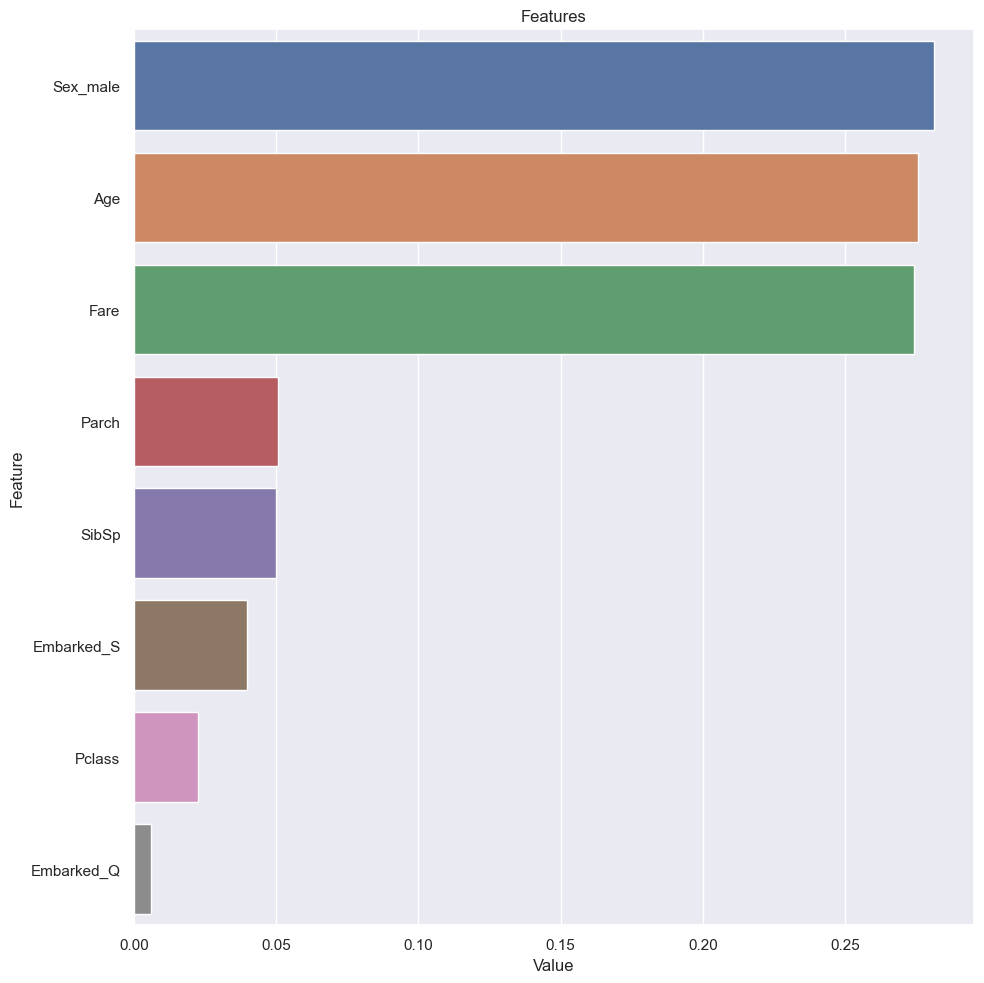

In [190]:
plot_importance(rf_model, X_train)
